In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'NanumGothic'

# 데이터 로드

In [3]:
!pip install finance-datareader

In [4]:
import FinanceDataReader as fdr

In [7]:
# 삼성전자 주가 데이터
samsung_code = '005930'
samsung = fdr.DataReader(samsung_code)

In [8]:
samsung.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2021-08-27,74300,75000,73800,74300,15172748,-0.004021
2021-08-30,75400,75500,74200,74600,12686999,0.004038
2021-08-31,74900,76700,74300,76700,24630370,0.028150
2021-09-01,76700,77100,75900,76800,16114775,0.001304
2021-09-02,76800,76800,75700,76000,15200268,-0.010417


In [9]:
samsung.index

DatetimeIndex(['1997-08-19', '1997-08-20', '1997-08-21', '1997-08-22',
               '1997-08-23', '1997-08-25', '1997-08-26', '1997-08-27',
               '1997-08-28', '1997-08-29',
               ...
               '2021-08-20', '2021-08-23', '2021-08-24', '2021-08-25',
               '2021-08-26', '2021-08-27', '2021-08-30', '2021-08-31',
               '2021-09-01', '2021-09-02'],
              dtype='datetime64[ns]', name='Date', length=6000, freq=None)

In [10]:
# index가 datetime type이므로 연,월,일 칼럼 생성
samsung['Year'] = samsung.index.year
samsung['Month'] = samsung.index.month
samsung['Day'] = samsung.index.day

In [11]:
samsung.tail()

,Open,High,Low,Close,Volume,Change,Year,Month,Day
Date,,,,,,,,,
2021-08-27,74300,75000,73800,74300,15172748,-0.004021,2021,8,27
2021-08-30,75400,75500,74200,74600,12686999,0.004038,2021,8,30
2021-08-31,74900,76700,74300,76700,24630370,0.028150,2021,8,31
2021-09-01,76700,77100,75900,76800,16114775,0.001304,2021,9,1
2021-09-02,76800,76800,75700,76000,15200268,-0.010417,2021,9,2


# 시각화

Text(0, 0.5, 'Closed price')

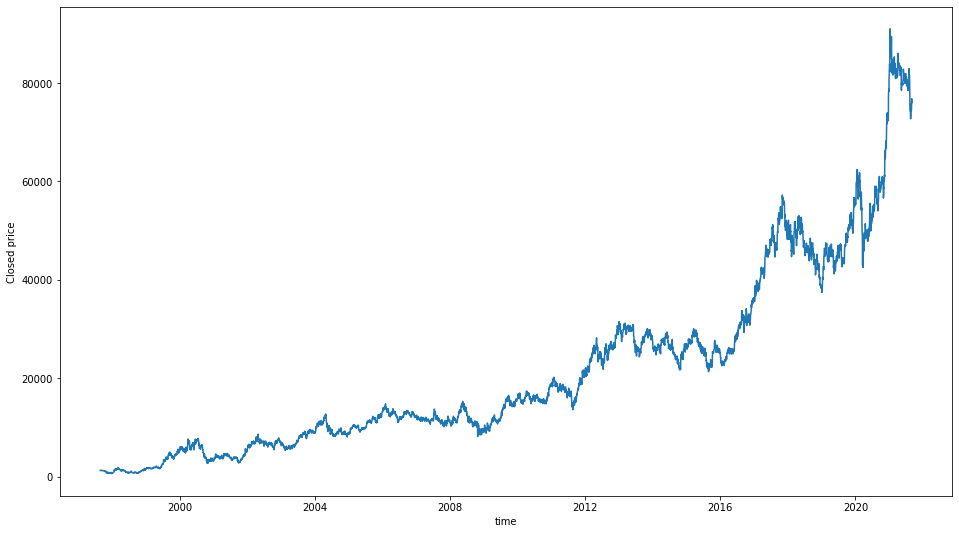

In [14]:
plt.figure(figsize=(16,9))
sns.lineplot(x=samsung.index, y=samsung['Close'])
plt.xlabel('time')
plt.ylabel('Closed price')

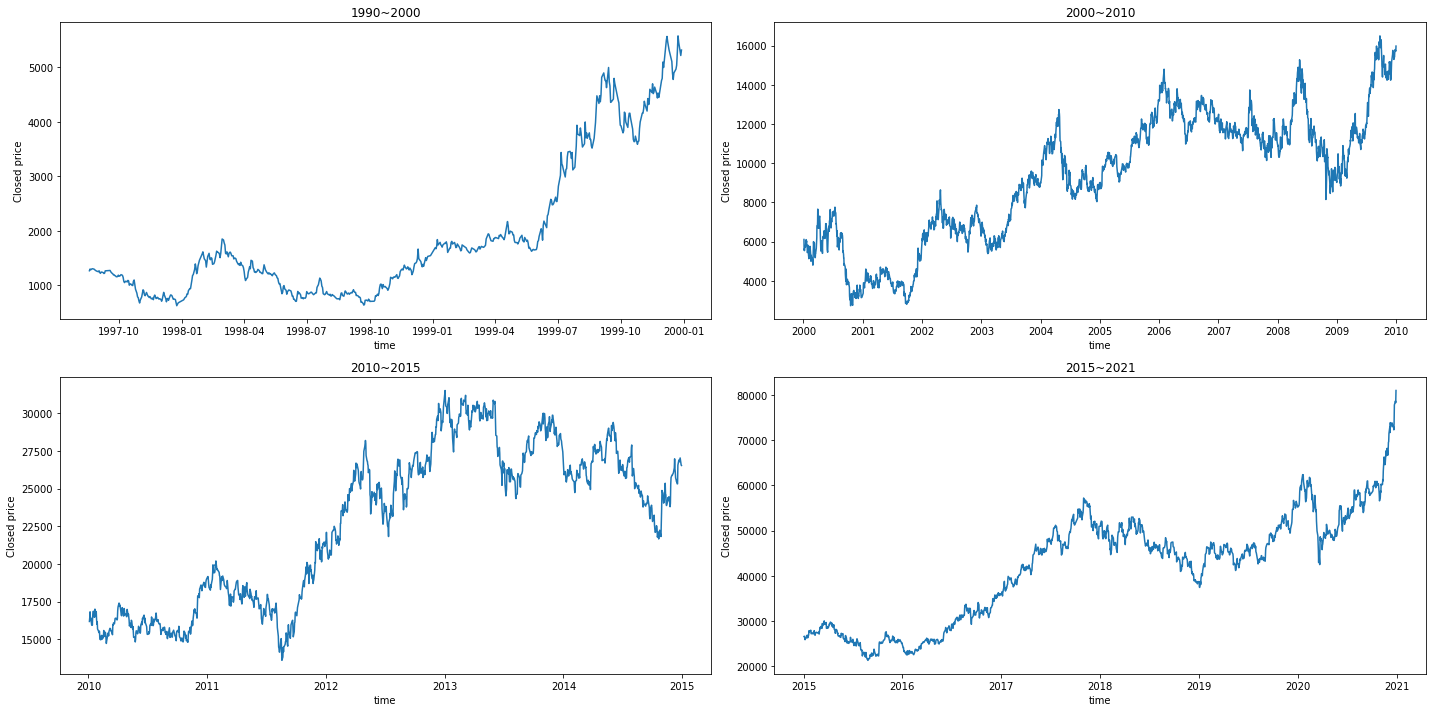

In [21]:
time_steps = [['1990', '2000'],
              ['2000', '2010'],
              ['2010', '2015'],
              ['2015', '2021']]

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(20,10)

for i in range(4):
  ax = axes[i//2, i%2]
  df = samsung.loc[(samsung.index > time_steps[i][0]) & (samsung.index < time_steps[i][1])]
  sns.lineplot(x=df.index, y=df['Close'], ax=ax)

  ax.set_title(f'{time_steps[i][0]}~{time_steps[i][1]}')
  ax.set_xlabel('time')
  ax.set_ylabel('Closed price')
plt.tight_layout()
plt.show()

# 데이터 전처리

정규화

In [23]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']

scaled = scaler.fit_transform(samsung[scale_cols])

In [24]:
df = pd.DataFrame(scaled, columns= scale_cols)

df.head()

,Open,High,Low,Close,Volume
0,0.014120,0.013171,0.013966,0.007104,0.000881
1,0.014042,0.013729,0.014067,0.007458,0.002415
2,0.014319,0.013564,0.014369,0.007303,0.001111
3,0.014241,0.013440,0.014212,0.007403,0.001111
4,0.014540,0.013564,0.014492,0.007513,0.000800


# train set/ test set 

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, random_state=0, shuffle=False)

In [27]:
x_train.shape, y_train.shape

((4800, 4), (4800,))

In [28]:
x_test.shape, y_test.shape

((1200, 4), (1200,))

# TensorFlow Dataset을 활용하여 시퀀스 데이터셋 구성

In [29]:
import tensorflow as tf

In [46]:
# Hyperparameter

WINDOW_SIZE = 5
BATCH_SIZE = 10

In [47]:
# X 값 Window Dataset 구성
# numpy array를 dataset 클래스로 변환
ds_x = tf.data.Dataset.from_tensor_slices(x_train)
ds_x = ds_x.window(WINDOW_SIZE, stride=1, shift=1, drop_remainder=True)
ds_x = ds_x.flat_map(lambda x: x.batch(WINDOW_SIZE))

In [48]:
# y값 Window Dataset 구성
ds_y = tf.data.Dataset.from_tensor_slices(y_train[WINDOW_SIZE:])

In [49]:
train_data = tf.data.Dataset.zip((ds_x, ds_y)).batch(32)

In [50]:
for x, y in train_data.take(1):
  print(x[:3])
  print()
  print(y[:3])

tf.Tensor(
[[[0.0141196  0.01317149 0.01396648 0.00088111]
  [0.01404208 0.01372934 0.01406704 0.00241545]
  [0.01431894 0.01356405 0.01436872 0.00111111]
  [0.01424142 0.01344008 0.01421229 0.00111147]
  [0.01454042 0.01356405 0.01449162 0.00080039]]

 [[0.01404208 0.01372934 0.01406704 0.00241545]
  [0.01431894 0.01356405 0.01436872 0.00111111]
  [0.01424142 0.01344008 0.01421229 0.00111147]
  [0.01454042 0.01356405 0.01449162 0.00080039]
  [0.01449612 0.01356405 0.01436872 0.00080083]]

 [[0.01431894 0.01356405 0.01436872 0.00111111]
  [0.01424142 0.01344008 0.01421229 0.00111147]
  [0.01454042 0.01356405 0.01449162 0.00080039]
  [0.01449612 0.01356405 0.01436872 0.00080083]
  [0.01428571 0.01341942 0.01434637 0.00079419]]], shape=(3, 5, 4), dtype=float64)

tf.Tensor([0.00745798 0.00740265 0.00725881], shape=(3,), dtype=float64)


In [51]:
pd.concat([x_train, y_train], axis=1).head(10)

,Open,High,Low,Volume,Close
0,0.014120,0.013171,0.013966,0.000881,0.007104
1,0.014042,0.013729,0.014067,0.002415,0.007458
2,0.014319,0.013564,0.014369,0.001111,0.007303
3,0.014241,0.013440,0.014212,0.001111,0.007403
4,0.014540,0.013564,0.014492,0.000800,0.007513
5,0.014496,0.013564,0.014369,0.000801,0.007458
6,0.014286,0.013419,0.014346,0.000794,0.007403
7,0.014241,0.013378,0.014335,0.001365,0.007259
8,0.014208,0.013264,0.014168,0.002116,0.007159
9,0.014009,0.013378,0.014034,0.001656,0.007060


In [55]:
def windowed_dataset(x, y, window_size, batch_size, shuffle):
  # X값 window dataset구성
  ds_x = tf.data.Dataset.from_tensor_slices(x)
  ds_x = ds_x.window(WINDOW_SIZE, shift=1, stride=1, drop_remainder=True)
  ds_x = ds_x.flat_map(lambda x : x.batch(WINDOW_SIZE))

  # Y값 window dataset 구성
  ds_y = tf.data.Dataset.from_tensor_slices(y[WINDOW_SIZE:])

  ds = tf.data.Dataset.zip((ds_x, ds_y))
  if shuffle:
    ds = ds.shuffle(1000)

  return ds.batch(batch_size).prefetch(1)

In [57]:
train_data = windowed_dataset(x_train, y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(x_test, y_test, WINDOW_SIZE, BATCH_SIZE, False)

# 모델

In [52]:
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [53]:
model = Sequential([
                    Conv1D(filters=32, kernel_size=5, padding='causal',
                           activation='relu', input_shape=[WINDOW_SIZE, 4]),
                    LSTM(16, activation='tanh'),
                    Dense(16, activation='relu'),
                    Dense(1)
])

In [54]:
loss = Huber()
optimizer= Adam(0.0005)

model.compile(loss=loss, optimizer=optimizer, metrics=['mse'])

In [58]:
earlystopping = EarlyStopping(monitor='val_loss', patience=10)

checkpoint_path = 'stock_checkpoint.ckpt'
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             save_weights_only=True,
                             save_vest_only=True,
                             monitor='val_loss',
                             verbose=1)

In [59]:
history = model.fit(train_data,
                    validation_data= (test_data),
                    epochs=50,
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
480/480 [==============================] - 5s 7ms/step - loss: 2.6735e-05 - mse: 5.3470e-05 - val_loss: 0.0026 - val_mse: 0.0053

Epoch 00001: saving model to stock_checkpoint.ckpt
Epoch 2/50
480/480 [==============================] - 3s 6ms/step - loss: 1.7139e-05 - mse: 3.4278e-05 - val_loss: 0.0022 - val_mse: 0.0045

Epoch 00002: saving model to stock_checkpoint.ckpt
Epoch 3/50
480/480 [==============================] - 3s 6ms/step - loss: 1.6847e-05 - mse: 3.3694e-05 - val_loss: 0.0022 - val_mse: 0.0044

Epoch 00003: saving model to stock_checkpoint.ckpt
Epoch 4/50
480/480 [==============================] - 3s 6ms/step - loss: 1.6215e-05 - mse: 3.2430e-05 - val_loss: 0.0024 - val_mse: 0.0049

Epoch 00004: saving model to stock_checkpoint.ckpt
Epoch 5/50
480/480 [==============================] - 3s 6ms/step - loss: 1.5050e-05 - mse: 3.0100e-05 - val_loss: 0.0025 - val_mse: 0.0050

Epoch 00005: saving model to stock_checkpoint.ckpt
Epoch 6/50
480/480 [====================

In [60]:
model.load_weights(checkpoint_path)

In [61]:
pred = model.predict(test_data)

# 시각화

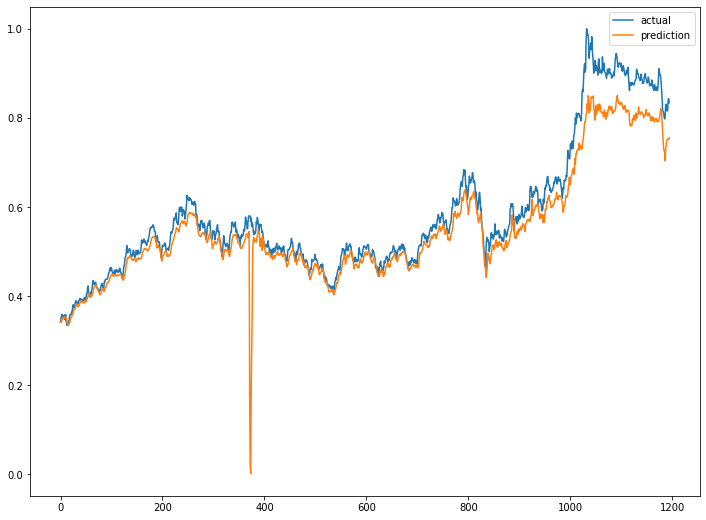

In [63]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[5:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()